In [1]:
import pandas as pd

## 1.	Use S&P 500 futures tick data taken fromhttps://www.kaggle.com/datasets/finnhub/sp-500-futures-tick-data-sp. 
### Save it as SP.csv. Remove the rows with 0 volume and then proceed.

In [2]:
sp = pd.read_csv('../data/SP.csv')


In [3]:
# Convert time column to string format first, then combine
sp['date_time'] = pd.to_datetime(sp['date'].astype(str) + ' ' + sp['time'].astype(str))

In [4]:
# sp_process for later use
sp = sp[['date_time', 'price', 'volume']].copy()

In [5]:
#TIME BARS Using MLFinLab
from mlfinlab.data_structures import time_data_structures

time_bars = time_data_structures.get_time_bars(
    sp, resolution="D", verbose=False
)

<frozen mlfinlab.util.fast_ewma>:17: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.


In [6]:
len(time_bars)

5977

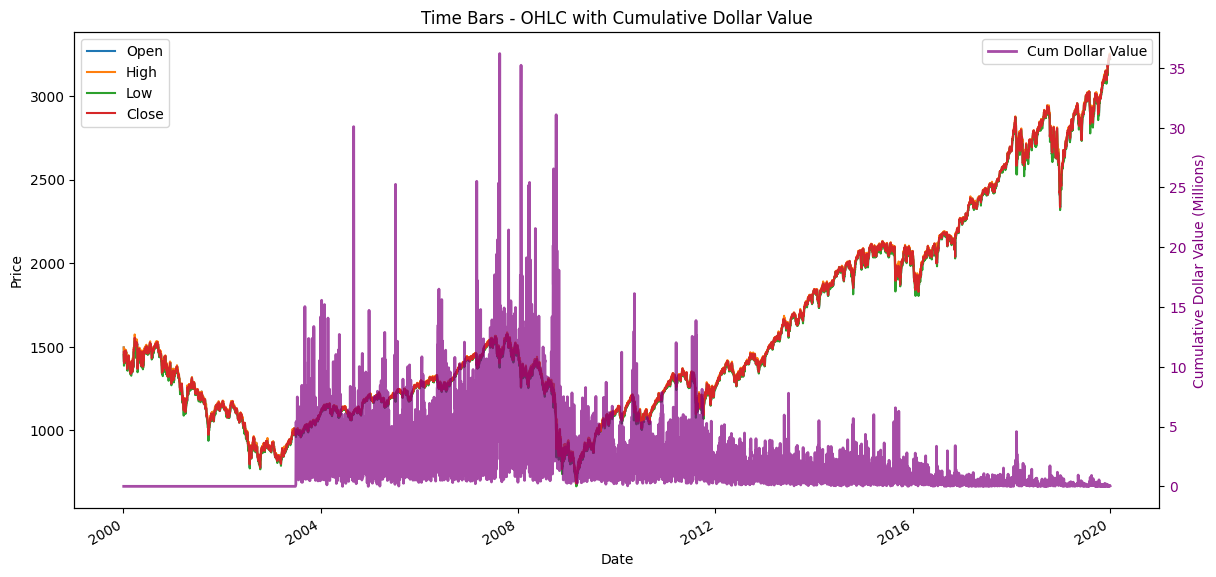

In [7]:
import matplotlib.pyplot as plt

# Plot all OHLC data with cum_dollar_value on secondary axis
fig, ax = plt.subplots(figsize=(14, 7))

# Plot OHLC on left axis
time_bars[['open', 'high', 'low', 'close']].plot(ax=ax)

# Create secondary y-axis for cum_dollar_value (in millions)
ax2 = ax.twinx()
(time_bars['cum_dollar_value'] / 1e6).plot(ax=ax2, color='purple', linewidth=2, label='Cum Dollar Value', alpha=0.7)

# Labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax2.set_ylabel('Cumulative Dollar Value (Millions)', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

plt.title('Time Bars - OHLC with Cumulative Dollar Value')
ax.legend(['Open', 'High', 'Low', 'Close'], loc='upper left')
ax2.legend(loc='upper right')
plt.show()

### Get rid of the Zero Volume data
But note also that the volume is farly steady between 2004 and 2008 the gradually trails off.
I think the volume migrated from the ES contract to SPY

In [8]:
#sp = sp.loc[pd.to_datetime(sp['date'].astype(str)) > pd.Timestamp('2003-06-30')].copy()
#sp = sp_read.loc[pd.to_datetime(sp_read['date'].astype(str)) >= pd.Timestamp('2004-01-01')].copy()
sp = sp[sp['volume'] != 0]

In [9]:
sp.head()

,date_time,price,volume
2812944,2003-06-30 23:00:06,971.9,1
2812945,2003-06-30 23:00:14,972.0,1
2812946,2003-06-30 23:04:16,972.0,1
2812947,2003-06-30 23:04:34,972.0,9
2812948,2003-06-30 23:05:02,972.0,91


In [10]:
#Check for zero volume rows
print(f"Rows with Volume = 0: {(sp['volume'] == 0).sum()}")

Rows with Volume = 0: 0


In [11]:
sp.describe(include='all')

,date_time,price,volume
count,6498085,6.498085e+06,6.498085e+06
mean,2008-08-20 17:09:27.000917760,1.275834e+03,1.800299e+00
min,2003-06-30 23:00:06,6.711000e+02,1.000000e+00
25%,2006-06-12 04:50:56,1.113900e+03,1.000000e+00
50%,2008-06-05 06:20:22,1.251000e+03,1.000000e+00
75%,2010-07-16 06:26:15,1.389700e+03,2.000000e+00
max,2019-12-31 02:21:45.011000,3.253500e+03,4.086000e+03
std,NaN,2.756042e+02,9.512023e+00


### Create sp_processed and limit the data to between 2010 and 2016

In [12]:
# sp_process for later use
sp_processed = sp[['date_time', 'price', 'volume']].copy()

# Filter to only 2010-2016
sp_processed = sp_processed[(sp_processed['date_time'] >= '2010-01-01') & 
                            (sp_processed['date_time'] < '2016-01-01')]

### Look at Time Bars for cleaned up data

In [13]:
#TIME BARS Using MLFinLab

time_bars = time_data_structures.get_time_bars(
    sp_processed, resolution="D", verbose=False
)

In [14]:
# Plotly plot with controls
import plotly.graph_objects as go

fig = go.Figure(data=[go.Candlestick(x=time_bars[:].index,
                open=time_bars['open'],
                high=time_bars['high'],
                low=time_bars['low'],
                close=time_bars['close'])])
fig.update_layout(title='Time Bars - Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()

In [15]:
len(time_bars)

1862

Plot time_bars vs cum_dollar_value

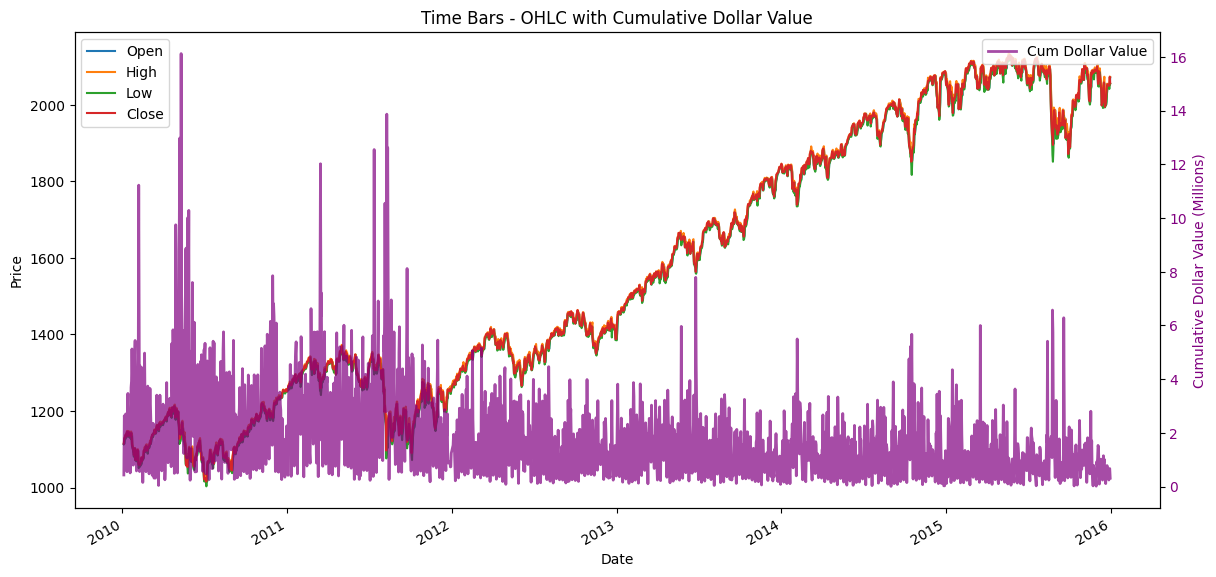

In [16]:

# Plot all OHLC data with cum_dollar_value on secondary axis
fig, ax = plt.subplots(figsize=(14, 7))

# Plot OHLC on left axis
time_bars[['open', 'high', 'low', 'close']].plot(ax=ax)

# Create secondary y-axis for cum_dollar_value (in millions)
ax2 = ax.twinx()
(time_bars['cum_dollar_value'] / 1e6).plot(ax=ax2, color='purple', linewidth=2, label='Cum Dollar Value', alpha=0.7)

# Labels and legend
ax.set_xlabel('Date')
ax.set_ylabel('Price')
ax2.set_ylabel('Cumulative Dollar Value (Millions)', color='purple')
ax2.tick_params(axis='y', labelcolor='purple')

plt.title('Time Bars - OHLC with Cumulative Dollar Value')
ax.legend(['Open', 'High', 'Low', 'Close'], loc='upper left')
ax2.legend(loc='upper right')
plt.show()

## 2.	Form dollar bars for the data from Exercise 1 above.

In [17]:
from mlfinlab.data_structures import standard_data_structures
# Compare different thresholds
for threshold in [1e6, 1.5e6, 2e6, 5e6]:
    bars = standard_data_structures.get_dollar_bars(sp_processed, threshold=threshold, batch_size=1000000, verbose=False)
    print(f"Threshold ${threshold/1e6:.1f}M: {len(bars)} bars")

Threshold $1.0M: 3811 bars
Threshold $1.5M: 2543 bars
Threshold $2.0M: 1908 bars
Threshold $5.0M: 763 bars


### Set Threshold to $2.0 million

In [18]:
#DOLLAR BARS Using MLFinLab

dollar_bars = standard_data_structures.get_dollar_bars(
    sp_processed, threshold=2000000, batch_size=1000000, verbose=False
)

print(f"Dollar bars shape: {dollar_bars.shape}")

Dollar bars shape: (1908, 9)


### Look at last 1000

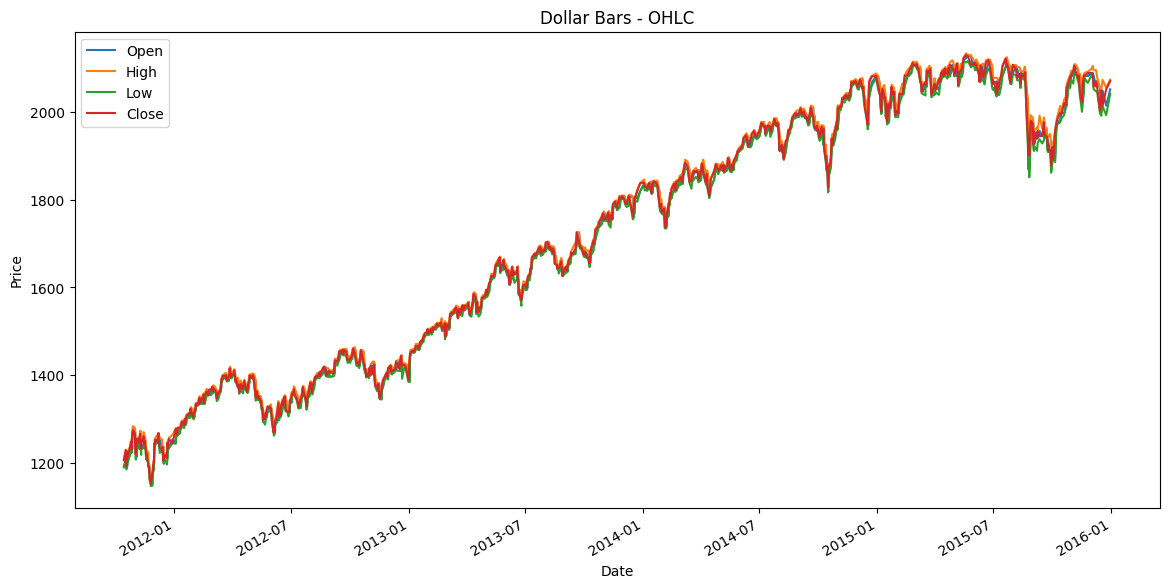

In [19]:
# DOLLAR BARS Plot OHLC data Last 1000
fig, ax = plt.subplots(figsize=(14, 7))
dollar_bars[-1000:][['open', 'high', 'low', 'close']].plot(ax=ax)
plt.title('Dollar Bars - OHLC')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Open', 'High', 'Low', 'Close'])
plt.show()

### Look at first 500

In [20]:
# Dollar Bars Analysis

fig = go.Figure(data=[go.Candlestick(x=dollar_bars[:500].index,
                open=dollar_bars['open'],
                high=dollar_bars['high'],
                low=dollar_bars['low'],
                close=dollar_bars['close'])])
fig.update_layout(title='Dollar Bars - Candlestick Chart', xaxis_title='Date', yaxis_title='Price')
fig.show()

In [21]:
'''Snippet 3.1 - Daily Volatility Estimates'''

# def getdailyVol(close, span0=100):
#     df0 = close.index.searchsorted(close.index - pd.Timedelta(days=1))
#     df0 = df0[df0 > 0]
#     df0 = pd.Series(close.index[df0 - 1], index=close.index[close.shape[0] - df0.shape[0]:])
#     df0 = close.loc[df0.index]/close.loc[df0.values].values - 1.0
#     df0 = df0.ewm(span=span0).std()
#     return df0

'Snippet 3.1 - Daily Volatility Estimates'

In [22]:
# From GPT-5

def get_daily_vol(close, span=100, lookback=pd.Timedelta('1D')):
    # Ensure we are working with a datetime index Series
    if isinstance(close, pd.DataFrame):
        if 'close' not in close.columns:
            raise ValueError("DataFrame must have a 'close' column.")
        close = close['close']
    if 'date_time' in getattr(close, 'columns', []):
        close = close.set_index('date_time')['close']
    close = close.sort_index()
    if not isinstance(close.index, pd.DatetimeIndex):
        raise ValueError("Input series must have a DatetimeIndex.")

    prev = close.index.searchsorted(close.index - lookback)
    prev = prev[prev > 0]
    prev_ts = pd.Series(close.index[prev - 1], index=close.index[-prev.shape[0]:])
    returns = close.loc[prev_ts.index] / close.loc[prev_ts.values].values - 1
    return returns.ewm(span=span).std()

In [23]:
'''Snippet 2.4 the Symetric CUSUM Filter'''

# def getTEvents(gRaw, h):
#     tEvents, sPos, sNeg = [], 0, 0
#     diff = gRaw.diff()
#     for i in diff.index[1:]:
#         sPos = max(0, sPos + diff.loc[i])
#         sNeg = min(0, sNeg + diff.loc[i])
#         # Use dynamic threshold if h is a Series, skip if not available
#         if isinstance(h, pd.Series):
#             if i not in h.index:
#                 continue
#             threshold = h.loc[i]
#         else:
#             threshold = h
#         if sNeg < -threshold:
#             sNeg = 0
#             tEvents.append(i)
#         elif sPos > threshold:
#             sPos = 0
#             tEvents.append(i)
#     return pd.DatetimeIndex(tEvents)

'Snippet 2.4 the Symetric CUSUM Filter'

In [24]:
'''Modified Snippet 2.4 the Symetric CUSUM Filter'''
# From GPT-5
def get_t_events(price, h):
    price = price.sort_index()
    if isinstance(h, pd.Series):
        h = h.reindex(price.index)
    diff = price.diff().dropna()
    t_events, s_pos, s_neg = [], 0.0, 0.0

    for t in diff.index:
        s_pos = max(0.0, s_pos + diff.loc[t])
        s_neg = min(0.0, s_neg + diff.loc[t])
        threshold = h.loc[t] if isinstance(h, pd.Series) else h
        if pd.isna(threshold):
            continue
        if s_neg < -threshold:
            s_neg = 0.0
            t_events.append(t)
        elif s_pos > threshold:
            s_pos = 0.0
            t_events.append(t)
    return pd.DatetimeIndex(t_events)

### I originally looked at daily vol from Time Bars then switched to Dollar Bars 
too lazy to update the code.

In [25]:
dv = get_daily_vol(dollar_bars['close'], span=100)
dv_dollar = dv

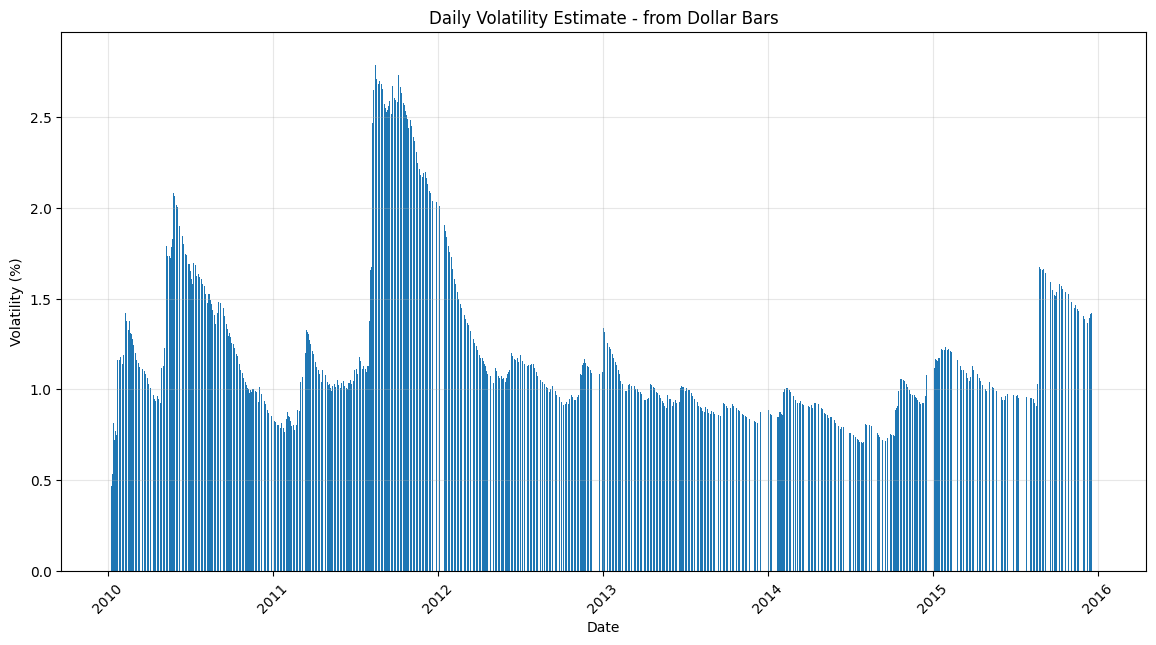

In [26]:
fig, ax = plt.subplots(figsize=(14, 7))
ax.bar(dv.index, dv * 100, width=1)
plt.title('Daily Volatility Estimate - from Dollar Bars')
plt.xlabel('Date')
plt.ylabel('Volatility (%)')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.show()

## This took some figuring

### (a)	Apply a symmetric CUSUM filter (Chapter 2, Section 2.5.2.1) where the threshold is the standard deviation of daily returns (Snippet 3.1).

        get_daily_vol is Snippet 3.1

dv_dollar is percent change but the CUMSUM is looking for dollar change.

Use threshold_dollars

In [27]:

threshold_dollars = dv_dollar * dollar_bars['close']
devents = get_t_events(dollar_bars['close'], threshold_dollars * 1)

In [28]:
# Dollar Bars Analysis with date range control
start_date = '2010-01-01'
end_date = '2010-06-01'

# Filter data by date range
mask = (dollar_bars.index >= start_date) & (dollar_bars.index < end_date)
dollar_bars_filtered = dollar_bars[mask]

fig = go.Figure(data=[go.Candlestick(x=dollar_bars_filtered.index,
                open=dollar_bars_filtered['open'],
                high=dollar_bars_filtered['high'],
                low=dollar_bars_filtered['low'],
                close=dollar_bars_filtered['close'])])

# Add devents overlay
devents_subset = devents[devents.isin(dollar_bars_filtered.index)]
if len(devents_subset) > 0:
    devent_prices = dollar_bars.loc[devents_subset, 'close']
    fig.add_trace(go.Scatter(
        x=devents_subset,
        y=devent_prices,
        mode='markers',
        marker=dict(color='red', size=8, symbol='x'),
        name='T-Events'
    ))

fig.update_layout(
    title='Dollar Bars - Candlestick Chart with devents', 
    xaxis_title='Date', 
    yaxis_title='Price',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1, label="1m", step="month", stepmode="backward"),
                dict(count=6, label="6m", step="month", stepmode="backward"),
                dict(count=1, label="1y", step="year", stepmode="backward"),
                dict(step="all")
            ])
        ),
        rangeslider=dict(visible=True),
        type="date"
    )
)
fig.show()

#### (b)	Use Snippet 3.4 on a pandas series t1, where numDays=1.
ADDING A VERTICAL BARRIER

In [29]:
close = dollar_bars['close']

'''Snippet 3.4 ADDING A VERTICAL BARRIER - Bar-based instead of time-based'''

numBars = 1  # Number of bars ahead, not days

# For each event, find the bar that is numBars positions ahead
t1_indices = []
t1_values = []

for event in devents:
    event_pos = close.index.get_loc(event)
    t1_pos = min(event_pos + numBars, len(close) - 1)  # Don't go past the end
    t1_indices.append(event)
    t1_values.append(close.index[t1_pos])

t1 = pd.Series(t1_values, index=t1_indices)

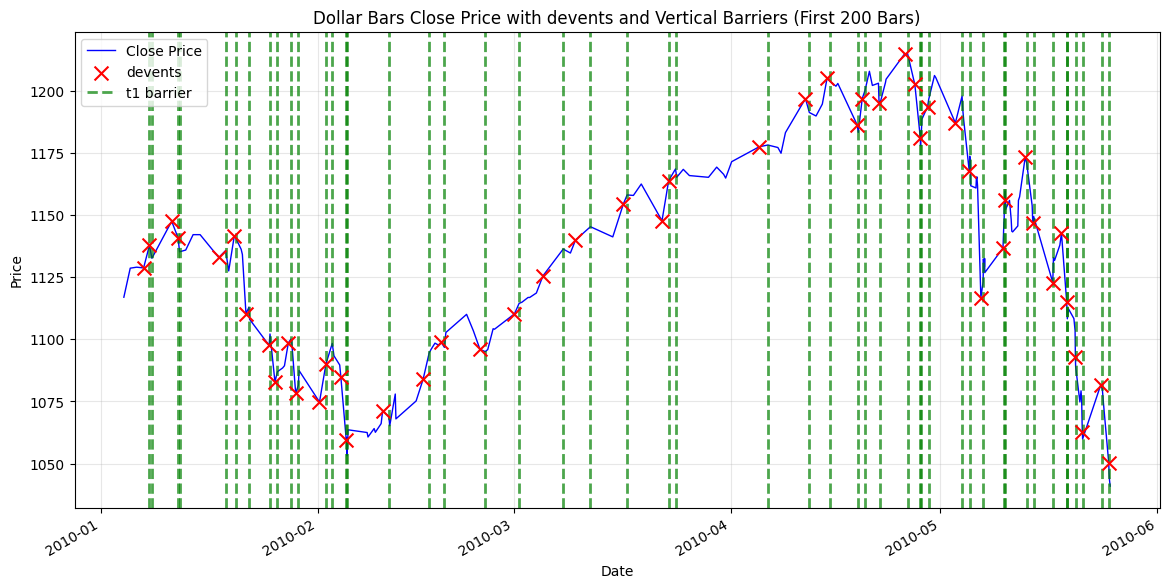

In [30]:
how_many = 200
# Create figure
fig, ax = plt.subplots(figsize=(14, 7))

# Plot first 50 close prices
dollar_bars['close'][:how_many].plot(ax=ax, label='Close Price', linewidth=1, color='blue')

# Filter data to first 50 bars
last_50_dates = dollar_bars[:how_many].index
devents_filtered = devents[devents.isin(last_50_dates)]

# Overlay devents with 'x' markers
if len(devents_filtered) > 0:
    devent_prices = dollar_bars.loc[devents_filtered, 'close']
    ax.scatter(devents_filtered, devent_prices, color='red', marker='x', s=100, 
               label='devents', zorder=5)
    
    # Add vertical lines for t1 barriers
    for t0 in devents_filtered:
        if t0 in t1.index:
            t1_date = t1.loc[t0]
            # Draw vertical line at t1 (removed the date range check)
            ax.axvline(x=t1_date, color='green', linestyle='dashed', alpha=0.7, linewidth=2,
                      label='t1 barrier' if t0 == devents_filtered[0] else '')

plt.title(f'Dollar Bars Close Price with devents and Vertical Barriers (First {how_many} Bars)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Debug info
#print(f"devents in range: {len(devents_filtered)}")
#print(f"t1 entries: {t1[t1.index.isin(devents_filtered)]}")

#### (c)	On those sampled features, apply the triple-barrier method, where ptSl=[1,1] and t1 is the series you created in part b.

In [31]:
'''Snippet 3.2 TRIPPLE-BARRIER LABELING METHOD'''

def applyPtSlOnT1(close, events, ptSl, molecule):
    events_ = events.loc[molecule]
    out = events_[['t1']].copy(deep=True)
    if ptSl[0] > 0:
        pt = ptSl[0] * events_['trgt']
    else:
        pt = pd.Series(index=events.index) #NaNa
    if ptSl[1] > 0:
        sl = -ptSl[1] * events_['trgt']
    else:
        sl = pd.Series(index=events.index) #NaNa
    for loc, t1 in events_['t1'].fillna(close.index[-1]).items():
        df0 = close[loc:t1]  # path prices
        df0 = (df0 / close[loc] - 1)  # path returns
        out.loc[loc, 'sl'] = df0[df0 < sl.loc[loc]].index.min()  # earliest stop loss
        out.loc[loc, 'pt'] = df0[df0 > pt.loc[loc]].index.min()  # earliest profit taking
    return out
    

In [32]:
# Create events DataFrame
events = pd.DataFrame(index=devents)
events['t1'] = t1  # vertical barrier
events['trgt'] = dv_dollar.reindex(devents)  # target/threshold for each event

# Apply triple barrier
TripleBarrierEvents = applyPtSlOnT1(close, events, ptSl=(1, 1), molecule=devents)

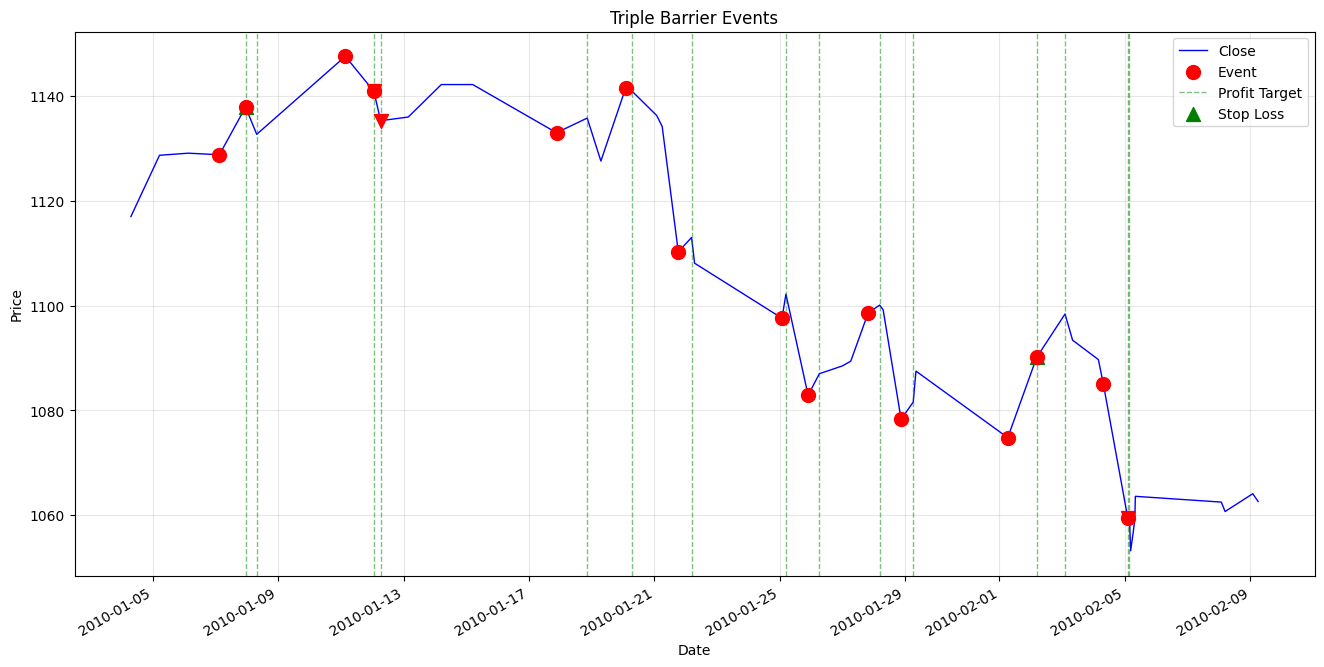

In [33]:
# Chart with triple barriers
how_many = 50
start_idx = 0

fig, ax = plt.subplots(figsize=(16, 8))

# Plot close prices
dollar_bars['close'][start_idx:start_idx+how_many].plot(ax=ax, label='Close Price', linewidth=1, color='blue')

# Filter events in range
range_dates = dollar_bars[start_idx:start_idx+how_many].index
events_in_range = TripleBarrierEvents[TripleBarrierEvents.index.isin(range_dates)]

for event_time in events_in_range.index:
    event_price = dollar_bars.loc[event_time, 'close']
    
    # Mark the event
    ax.scatter(event_time, event_price, color='red', marker='o', s=100, zorder=5)
    
    # Vertical barrier (t1)
    t1_time = events_in_range.loc[event_time, 't1']
    if pd.notna(t1_time):
        ax.axvline(x=t1_time, color='green', linestyle='--', alpha=0.5, linewidth=1)
    
    # Profit target (pt)
    pt_time = events_in_range.loc[event_time, 'pt']
    if pd.notna(pt_time):
        pt_price = dollar_bars.loc[pt_time, 'close']
        ax.scatter(pt_time, pt_price, color='green', marker='^', s=100, zorder=5)
    
    # Stop loss (sl)
    sl_time = events_in_range.loc[event_time, 'sl']
    if pd.notna(sl_time):
        sl_price = dollar_bars.loc[sl_time, 'close']
        ax.scatter(sl_time, sl_price, color='red', marker='v', s=100, zorder=5)

plt.title('Triple Barrier Events')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend(['Close', 'Event', 'Profit Target', 'Stop Loss'])
plt.grid(True, alpha=0.3)
plt.show()

#### (d)	Apply getBins to generate the labels.

In [34]:
import numpy as np
'''Snippet 3.5 LABELING FOR SIDE AND SIZE'''

def getBins(events, close):
    events_ = events.dropna(subset=['t1'])
    px = events_.index.union(events_['t1'].values).drop_duplicates()
    px = close.reindex(px, method='bfill')

    out = pd.DataFrame(index=events_.index)
    out['ret'] = px.loc[events_['t1'].values].values / px.loc[events_.index].values - 1.0
    out['bin'] = np.sign(out['ret'])
    return out


In [35]:
# Merge TripleBarrierEvents with events to get complete information
events_complete = events.copy()
events_complete['sl'] = TripleBarrierEvents['sl']
events_complete['pt'] = TripleBarrierEvents['pt']

# Determine which barrier was touched first for each event
# The t1 column should reflect whichever barrier was hit first (or vertical barrier if nothing hit)
for idx in events_complete.index:
    barriers = [events_complete.loc[idx, 'pt'], 
                events_complete.loc[idx, 'sl'], 
                events_complete.loc[idx, 't1']]
    # Get the earliest non-NaT barrier
    barriers_valid = [b for b in barriers if pd.notna(b)]
    if barriers_valid:
        events_complete.loc[idx, 't1'] = min(barriers_valid)

# Apply getBins to generate labels
labels = getBins(events_complete, close)
#labels

#### 3.	On data from Exercise 1 above, use Snippet 3.8 to drop rare labels.

In [36]:
# First, check the current label distribution
print("Original label distribution:")
print(labels['bin'].value_counts(normalize=True))
print(f"\nTotal samples: {len(labels)}")

Original label distribution:
bin
 1.0    0.562384
-1.0    0.433892
 0.0    0.003724
Name: proportion, dtype: float64

Total samples: 537


In [37]:
'''Snippet 3.8 DROPPING UNDER-POPULATED LABELS'''

def dropLabels(events, minPtc=0.05):

    while True:
        df0 = events['bin'].value_counts(normalize=True)
        if df0.min() > minPtc or df0.shape[0] <= 3:
            break
        print( 'dropped label', df0.argmin())
        events = events[events['bin'] != df0.argmin()]
    return events

In [38]:
# Apply dropLabels to remove rare labels (less than 5%)
labels_filtered = dropLabels(labels, minPtc=0.05)

print("\n\nFiltered label distribution:")
print(labels_filtered['bin'].value_counts(normalize=True))
print(f"\nRemaining samples: {len(labels_filtered)}")
print(f"Dropped samples: {len(labels) - len(labels_filtered)}")



Filtered label distribution:
bin
 1.0    0.562384
-1.0    0.433892
 0.0    0.003724
Name: proportion, dtype: float64

Remaining samples: 537
Dropped samples: 0
